In [1]:
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization (for inspection)
import matplotlib.pyplot as plt
import seaborn as sns


# Cleaning


In [10]:
# Load CSV file
df = pd.read_csv("mymoviedb.csv",engine='python')

# Quick look
df.head()


,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [11]:
print(df.shape)
df.info()


(9837, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9837 entries, 0 to 9836
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release_Date       9837 non-null   object 
 1   Title              9828 non-null   object 
 2   Overview           9828 non-null   object 
 3   Popularity         9827 non-null   float64
 4   Vote_Count         9827 non-null   object 
 5   Vote_Average       9827 non-null   object 
 6   Original_Language  9827 non-null   object 
 7   Genre              9826 non-null   object 
 8   Poster_Url         9826 non-null   object 
dtypes: float64(1), object(8)
memory usage: 691.8+ KB


In [12]:
df.isnull().sum()

Release_Date          0
Title                 9
Overview              9
Popularity           10
Vote_Count           10
Vote_Average         10
Original_Language    10
Genre                11
Poster_Url           11
dtype: int64

In [16]:
df = df.dropna(subset=["Title", "Overview", "Genre"])
df["Overview"] = df["Overview"].astype(str)
df = df.drop_duplicates(subset=["Title","Release_Date"])

print("Cleaned dataset size:", df.shape)



Cleaned dataset size: (9512, 9)


# Text Preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text) 
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [19]:
df["clean_overview"] = df["Overview"].apply(clean_text)
df["clean_genre"] = df["Genre"].apply(clean_text)


In [23]:
df["movie_profile"] = df["clean_overview"] + " " + df["clean_genre"]


df[["Title", "movie_profile"]].head()


,Title,movie_profile
0,Spider-Man: No Way Home,peter parker unmasked longer able separate nor...
1,The Batman,second year fighting crime batman uncovers cor...
2,No Exit,stranded rest stop mountain blizzard recoverin...
3,Encanto,tale extraordinary family madrigal live hidden...
4,The King's Man,collection history worst tyrant criminal maste...


In [200]:
df = df.reset_index(drop=True)


# TF-IDF

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [202]:
tfidf = TfidfVectorizer(
    max_features=10000,   # limit vocabulary size
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=3              # ignore very rare words
)

tfidf_matrix = tfidf.fit_transform(df["movie_profile"])
print("TF-IDF matrix shape:", tfidf_matrix.shape)



TF-IDF matrix shape: (9512, 10000)


In [203]:
tfidf.get_feature_names_out()[:100]


array(['aaron', 'abandon', 'abandoned', 'abby', 'abduct', 'abducted',
       'abduction', 'abducts', 'abe', 'abigail', 'ability', 'able',
       'able save', 'aboard', 'abraham', 'abroad', 'abrupt', 'absence',
       'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abusive',
       'academic', 'academy', 'accept', 'acceptance', 'accepted',
       'accepts', 'access', 'accident', 'accident leaf', 'accidental',
       'accidental death', 'accidentally', 'accidentally kill',
       'acclaimed', 'accompanied', 'accompanies', 'accompany',
       'accompanying', 'accomplice', 'accomplish', 'accomplished',
       'according', 'account', 'accountant', 'accused', 'accused killing',
       'accused murder', 'accused murdering', 'ace', 'achieve',
       'achieved', 'acquaintance', 'acre', 'acre wood', 'across',
       'across america', 'across country', 'across globe',
       'across street', 'act', 'act violence', 'acting', 'action',
       'action adventure', 'action animation', 'action 

# PCA

In [204]:
from sklearn.decomposition import TruncatedSVD


In [205]:
n_components = 200  # good trade-off

svd = TruncatedSVD(n_components=n_components, random_state=42)
pca_features = svd.fit_transform(tfidf_matrix)



In [206]:
explained_variance = svd.explained_variance_ratio_
print("Total explained variance:", explained_variance.sum())


Total explained variance: 0.19799072951910582


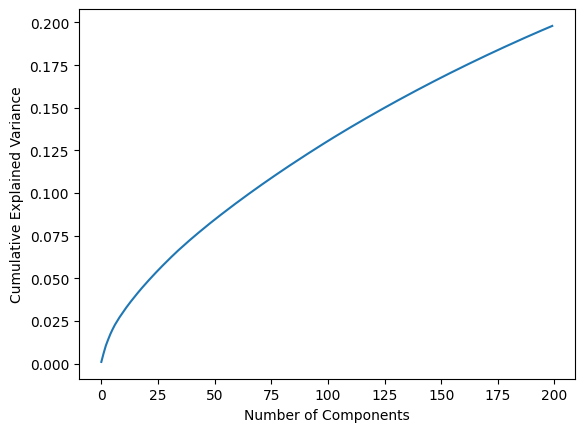

In [207]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


# GMM

In [208]:
from sklearn.mixture import GaussianMixture


In [209]:
bic_scores = []
aic_scores = []
k_range = range(1, 31)  # try 5 → 30 clusters

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(pca_features)
    bic_scores.append(gmm.bic(pca_features))
    aic_scores.append(gmm.aic(pca_features))


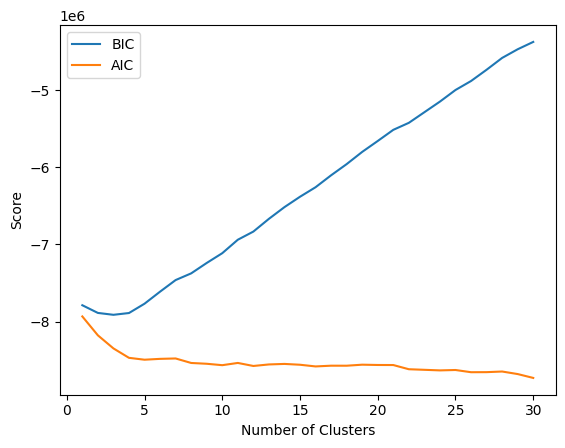

In [225]:
plt.plot(k_range, bic_scores, label="BIC")
plt.plot(k_range, aic_scores, label="AIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


In [211]:
optimal_k = 15

gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="full",
    random_state=42
)

gmm_labels = gmm.fit_predict(pca_features)


In [212]:
df["gmm_cluster"] = gmm_labels
gmm_probs = gmm.predict_proba(pca_features)
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}")
    sample_titles = df[df["gmm_cluster"] == cluster_id]["Title"].head(20)
    print(sample_titles.tolist())




Cluster 0
['Last Man Down', 'The 355', 'One Shot', 'Desperate Riders', 'Blacklight', 'Dangerous', 'No Time to Die', 'The Weekend Away', 'Fortress', 'Zeros and Ones', 'Crazy Fist', 'The Desperate Hour', 'Matando Cabos 2: La Máscara del Máscara', 'The Forever Purge', 'The Vault', 'Last Shoot Out', 'Undisputed III: Redemption', 'Brothers', 'The Protégé', 'The Marksman']

Cluster 1
['Spider-Man', 'After', 'Spider-Man: Into the Spider-Verse', 'Jujutsu Kaisen 0', 'El Paseo 6', 'Project X', 'Rascal Does Not Dream of a Dreaming Girl', 'Weathering with You', 'Grown Ups', 'Aquaslash', 'American Pie Presents: The Book of Love', 'Into the Wind', 'Palmer', 'No Manches Frida', 'Whispering Corridors 6: The Humming', 'Overcomer', 'The Kissing Booth', "Trinity Seven 2: Heaven's Library & Crimson Lord", "I'm Not Ashamed", 'Superbad']

Cluster 2
['Marry Me', 'Through My Window', "Tyler Perry's A Madea Homecoming", 'Cruella', 'After We Fell', 'Sex, Shame and Tears 2', 'Heart Shot', 'UFO', 'The Fallout', 

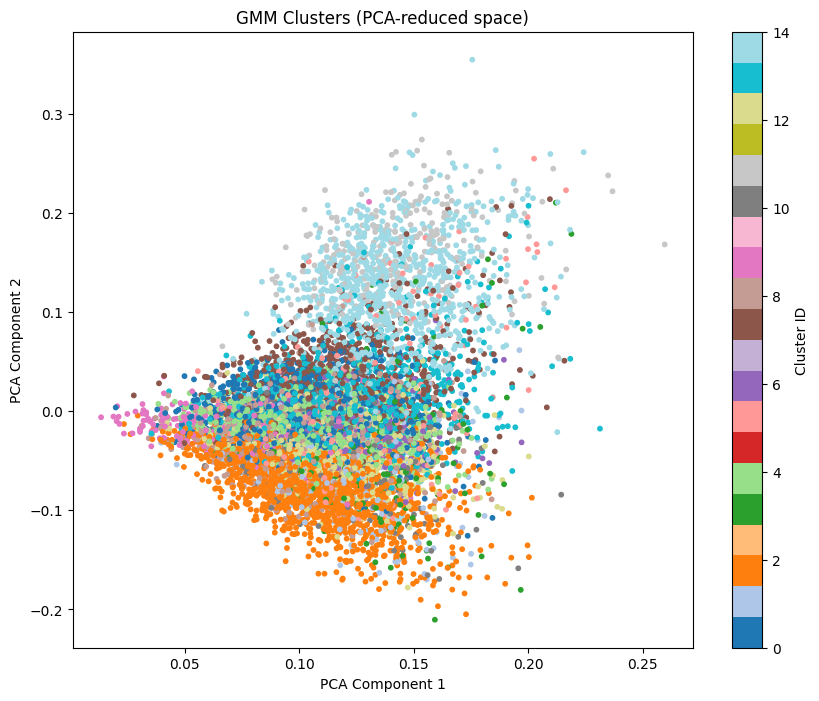

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=df["gmm_cluster"],
    cmap="tab20",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clusters (PCA-reduced space)")
plt.colorbar(label="Cluster ID")
plt.show()


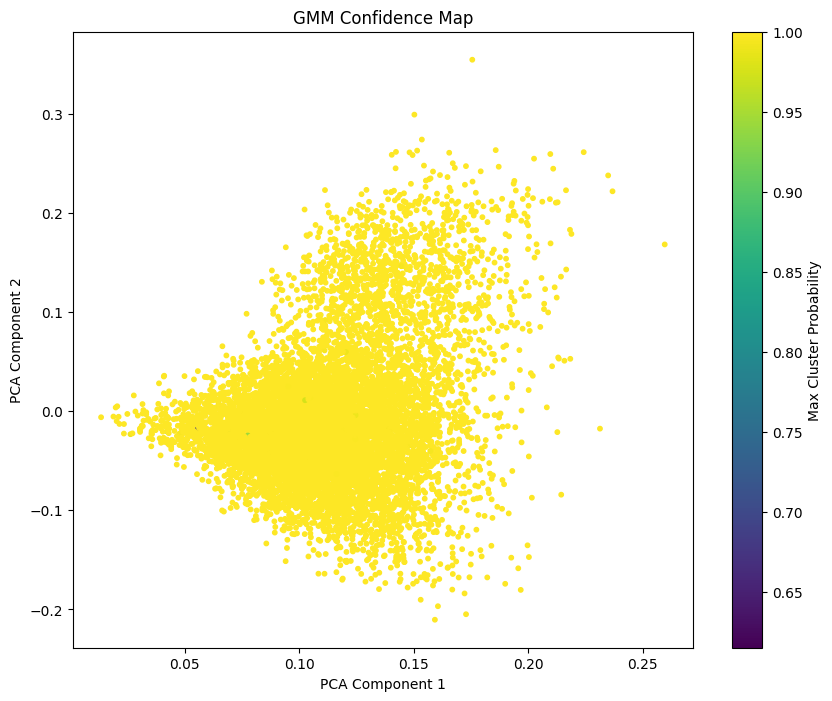

In [214]:
max_probs = gmm.predict_proba(pca_features).max(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=max_probs,
    cmap="viridis",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Confidence Map")
plt.colorbar(label="Max Cluster Probability")
plt.show()


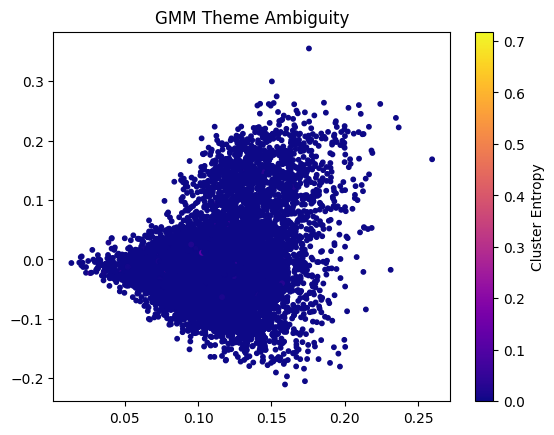

In [215]:
from scipy.stats import entropy

ent = entropy(probs.T)

plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=ent,
    cmap="plasma",
    s=10
)
plt.colorbar(label="Cluster Entropy")
plt.title("GMM Theme Ambiguity")
plt.show()


# remove outliers

In [216]:
from sklearn.cluster import DBSCAN


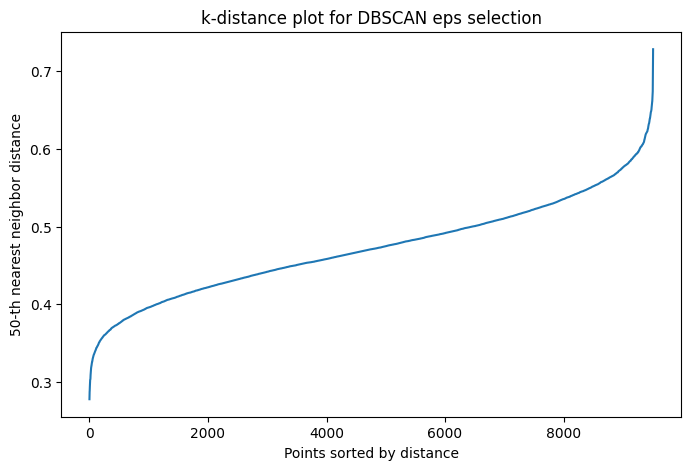

In [217]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 50 # try 30–50
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(pca_features)
distances, indices = neighbors_fit.kneighbors(pca_features)

# distance to kth nearest neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()


In [218]:
dbscan = DBSCAN(
    eps=0.57,
    min_samples=50
)

dbscan_labels = dbscan.fit_predict(pca_features)

df["dbscan_cluster"] = dbscan_labels



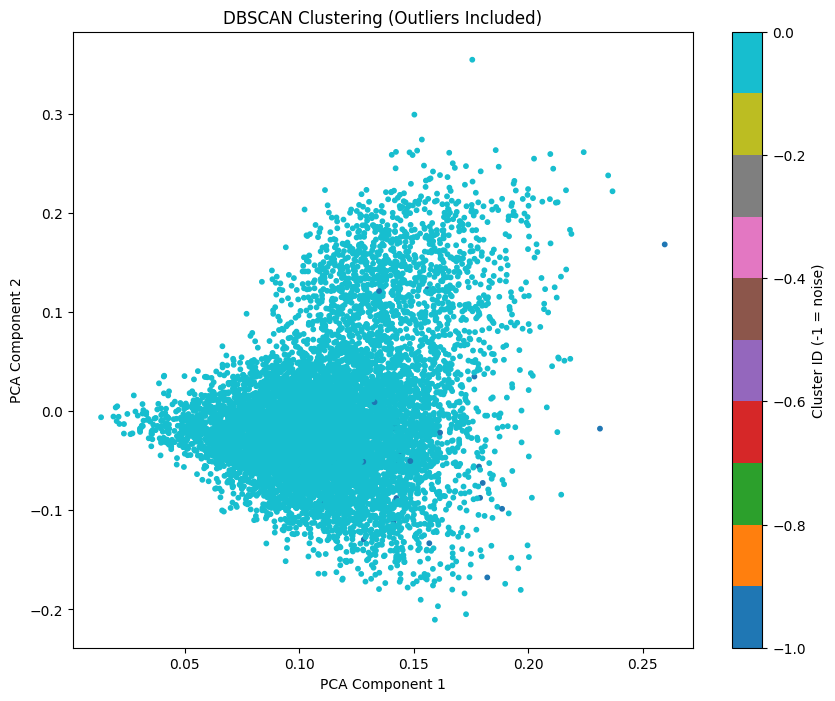

In [226]:
plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=dbscan_labels,
    cmap="tab10",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering (Outliers Included)")
plt.colorbar(label="Cluster ID (-1 = noise)")
plt.show()


In [220]:
outliers = df[df["dbscan_cluster"] == -1]
outliers["Title"].head(10)


236     Monster Pets: A Hotel Transylvania Short
460                    Pokémon Detective Pikachu
1211                                       Mirai
1215                              Xico's Journey
1974                           A Naija Christmas
2618                             Forever My Girl
3577                                   Showgirls
3648                             Moms' Night Out
4202                                    My Night
4243                                        Tusk
Name: Title, dtype: object

In [221]:
np.unique(dbscan_labels, return_counts=True)


(array([-1,  0]), array([  25, 9487]))

# recommendation

In [222]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(
    movie_title,
    df,
    tfidf_matrix,
    top_n=10
):
    # Find movie index safely
    matches = df.index[df["Title"].str.lower() == movie_title.lower()]
    
    if len(matches) == 0:
        raise ValueError("Movie title not found in dataset.")
    
    idx = matches[0]  # row position
    
    # Get its GMM cluster
    cluster_id = df.loc[idx, "gmm_cluster"]
    
    # Candidates: same cluster
    candidate_indices = df.index[df["gmm_cluster"] == cluster_id].to_numpy()
    
    # Compute cosine similarity
    similarities = cosine_similarity(
        tfidf_matrix[idx],
        tfidf_matrix[candidate_indices]
    ).flatten()
    
    # Rank
    top_positions = similarities.argsort()[::-1][1:top_n+1]
    top_indices = candidate_indices[top_positions]
    
    return df.loc[top_indices, ["Title", "Genre", "Vote_Average"]]


In [241]:
# call without passing the cluster array (the function uses df["gmm_cluster"] internally)
recommend_movies(
    "Fast & Furious",
    df,
    tfidf_matrix,
    top_n=10
)


,Title,Genre,Vote_Average
348,The Fate of the Furious,"Action, Crime, Thriller",6.9
7435,What Doesn't Kill You,"Action, Crime, Drama",6.1
6179,Reindeer Games,"Thriller, Action, Crime, Drama",5.6
3863,Mercury Rising,"Action, Crime, Drama, Thriller",6.2
75,F9,"Action, Crime, Thriller, Adventure",7.3
7356,A Better Tomorrow II,"Action, Crime, Thriller",7.1
473,Bad Boys for Life,"Thriller, Action, Crime",7.2
5699,Police Story: Lockdown,"Action, Crime, Drama, Thriller",6.0
3390,The Prey,"Action, Crime, Thriller",6.4
6584,Street Kings,"Action, Crime, Drama, Thriller",6.6


In [242]:
recommend_movies(
    "interstellar",
    df,
    tfidf_matrix,
    top_n=10
)

,Title,Genre,Vote_Average
6552,Midnight Special,"Adventure, Drama, Science Fiction",6.2
5348,Cocoon,"Comedy, Drama, Science Fiction",6.6
839,Star Wars: The Last Jedi,"Science Fiction, Action, Adventure",6.9
2991,Gattaca,"Thriller, Science Fiction, Mystery, Romance",7.6
4597,Last Man,"Drama, Science Fiction",0.0
3732,Okja,"Adventure, Drama, Science Fiction",7.4
4042,A.I. Artificial Intelligence,"Drama, Science Fiction, Adventure",7.0
274,Seobok: Project Clone,"Science Fiction, Action",7.6
6206,The Wolverine,"Action, Science Fiction, Adventure, Fantasy",6.4
4529,Street Fighter,"Action, Adventure, Thriller, Drama, Science Fi...",4.5


In [244]:
recommend_movies(
    "Harry Potter and the Philosopher's Stone",
    df,
    tfidf_matrix,
    top_n=10
)

,Title,Genre,Vote_Average
159,Harry Potter and the Chamber of Secrets,"Adventure, Fantasy",7.7
192,Harry Potter and the Prisoner of Azkaban,"Adventure, Fantasy",8.0
184,Harry Potter and the Goblet of Fire,"Adventure, Fantasy, Family",7.8
244,Harry Potter and the Order of the Phoenix,"Adventure, Fantasy, Mystery",7.7
217,Harry Potter and the Half-Blood Prince,"Adventure, Fantasy",7.7
252,Harry Potter and the Deathly Hallows: Part 2,"Fantasy, Adventure",8.1
3778,Epic Movie,"Comedy, Action, Adventure",3.9
305,Harry Potter and the Deathly Hallows: Part 1,"Adventure, Fantasy",7.8
132,The Amazing Spider-Man 2,"Action, Adventure, Fantasy",6.5
131,Wonder Woman 1984,"Action, Adventure, Fantasy",6.6
